In [25]:
import os
import time 
import uuid
import cv2

In [26]:
uuid.uuid1()

UUID('e912513e-a1b2-11ee-9f21-14d424183f4e')

In [27]:
IMAGES_PATH = os.path.join('data', 'images')
number_images = 30

lets get started with opencv

In [4]:
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [24]:
!labelme

[INFO   ] __init__:get_config:70 - Loading config file from: C:\Users\Cem\.labelmerc


In [29]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

In [30]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [31]:
tf.config.list_physical_devices('GPU')

[]

In [32]:
images = tf.data.Dataset.list_files('data\\images\\*.jpg')

In [33]:
images.as_numpy_iterator().next()

b'data\\images\\0319281d-a197-11ee-a326-14d424183f4e.jpg'

İmage`yi tensora çevirelim

In [34]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

Tüm imageleri tensor haline çevirelim

In [35]:
images = images.map(load_image)

tensorları geri numpy arraylerine çevirelim

In [36]:
images.as_numpy_iterator().next()

array([[[157, 141, 108],
        [156, 140, 107],
        [155, 139, 106],
        ...,
        [108, 124, 113],
        [108, 124, 113],
        [108, 124, 113]],

       [[155, 139, 106],
        [155, 139, 106],
        [154, 138, 105],
        ...,
        [108, 124, 113],
        [108, 124, 113],
        [108, 124, 113]],

       [[153, 134, 101],
        [154, 135, 102],
        [154, 135, 103],
        ...,
        [109, 125, 114],
        [108, 124, 113],
        [108, 124, 113]],

       ...,

       [[ 57,  37,  36],
        [ 59,  39,  38],
        [ 59,  39,  38],
        ...,
        [ 85,  81,  72],
        [ 87,  82,  76],
        [ 88,  83,  77]],

       [[ 60,  40,  39],
        [ 64,  44,  43],
        [ 64,  44,  43],
        ...,
        [ 84,  80,  71],
        [ 85,  80,  74],
        [ 85,  80,  74]],

       [[ 62,  42,  41],
        [ 67,  47,  46],
        [ 68,  48,  47],
        ...,
        [ 84,  80,  71],
        [ 86,  81,  75],
        [ 86,  81,  75]]

In [37]:
type(images)

tensorflow.python.data.ops.map_op._MapDataset

In [38]:
image_generator = images.batch(4).as_numpy_iterator()

In [39]:
plot_images = image_generator.next()

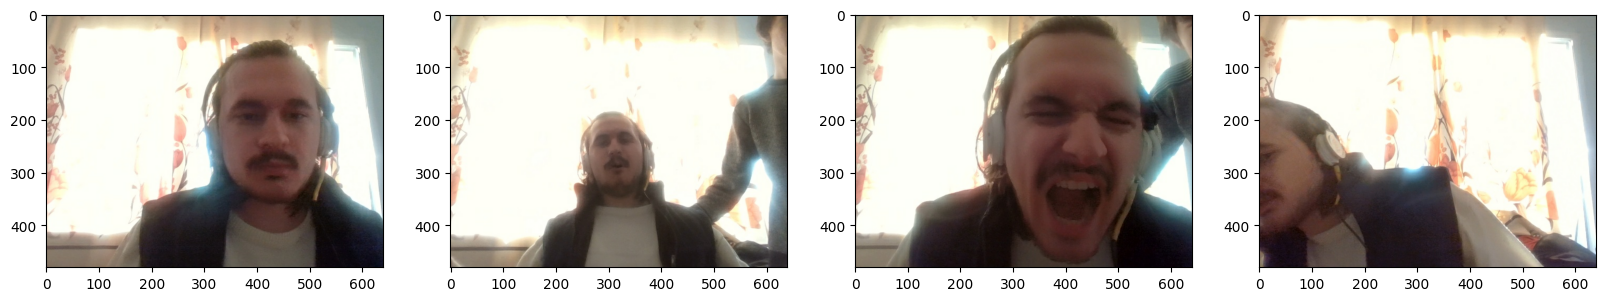

In [40]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

In [41]:
import random
import shutil

Train Validation ve Test dosyalarımızı hazırlayalım

In [42]:
def copy_percentage_of_files(source_folder, destination_folder, percentage):
    # Get a list of all files in the source folder
    all_files = os.listdir(source_folder)
    
    # Ensure there's at least one file to copy
    num_files_to_copy = max(1, int(len(all_files) * (percentage / 100)))
    
    # Randomly select files to copy
    files_to_copy = random.sample(all_files, num_files_to_copy)
    
    # Ensure the destination folder exists
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)
    
    # Copy selected files to the destination folder
    for file_name in files_to_copy:
        source_path = os.path.join(source_folder, file_name)
        destination_path = os.path.join(destination_folder, file_name)
        shutil.copy2(source_path, destination_path)
        print(f"Copied: {file_name}")

In [43]:
source_directory = './data/labels'
destination_directory = './data/test/labels'
percentage_to_copy = 15  # Adjust this percentage as needed

copy_percentage_of_files(source_directory, destination_directory, percentage_to_copy)

Copied: 2467689a-a197-11ee-8378-14d424183f4e.json
Copied: 086f9d6f-a197-11ee-9531-14d424183f4e.json


In [44]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath) 

In [45]:
import albumentations as alb

In [46]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

In [47]:
image_path = os.path.join('data', 'train', 'images', '0a026db6-a197-11ee-b889-14d424183f4e.jpg')
img = cv2.imread(image_path)

In [48]:
with open(os.path.join('data', 'train', 'labels', '0a026db6-a197-11ee-b889-14d424183f4e.json'), 'r') as f:
    label = json.load(f)

In [49]:
label['shapes'][0]['points']

[[240.1923076923077, 2.5000000000000284],
 [536.3461538461538, 315.96153846153845]]

In [50]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [51]:
coords

[240.1923076923077, 2.5000000000000284, 536.3461538461538, 315.96153846153845]

In [52]:
coords = list(np.divide(coords, [640,480,640,480]))

In [53]:
coords

[0.3753004807692308,
 0.005208333333333393,
 0.8380408653846153,
 0.6582532051282051]

In [54]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [55]:
augmented['bboxes'][0][2:]

(1.0, 1.0)

In [56]:
augmented['bboxes']

[(0.46042735042735045, 0.3556410256410256, 1.0, 1.0)]

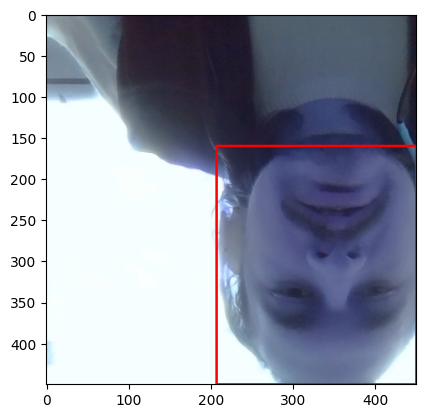

In [57]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

In [58]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('./data', partition, 'images')):
        img = cv2.imread(os.path.join('./data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('./data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('./aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('./aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

In [59]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [60]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [61]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [62]:
train_images.as_numpy_iterator().next()

array([[[0.627451  , 0.69166666, 0.652451  ],
        [0.62941176, 0.69080883, 0.66207105],
        [0.61942405, 0.6782476 , 0.6507966 ],
        ...,
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ]],

       [[0.6127451 , 0.67941177, 0.6401961 ],
        [0.6214461 , 0.68811274, 0.6557598 ],
        [0.6279412 , 0.69460785, 0.6622549 ],
        ...,
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ]],

       [[0.625674  , 0.6996936 , 0.65802693],
        [0.62800246, 0.6946691 , 0.65545344],
        [0.64270836, 0.709375  , 0.67015934],
        ...,
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ]],

       ...,

       [[0.52077204, 0.52567405, 0.47616422],
        [0.48131126, 0.46758577, 0.43376225],
        [0.45716912, 0

In [63]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

In [64]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.2349, 0.0881, 0.939 , 0.853 ], dtype=float16))

In [65]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(5040, 5040, 1080, 1080, 1080, 1080)

In [66]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.    , 0.2886, 0.4463, 0.789 ],
        [0.    , 0.1087, 0.4324, 0.7393],
        [0.4294, 0.2842, 0.921 , 0.784 ],
        [0.0626, 0.1329, 0.655 , 0.7427],
        [0.1628, 0.0851, 0.8223, 0.723 ],
        [0.    , 0.007 , 0.7373, 0.988 ],
        [0.339 , 0.1454, 0.9883, 0.941 ],
        [0.574 , 0.1827, 1.    , 0.9526]], dtype=float16))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


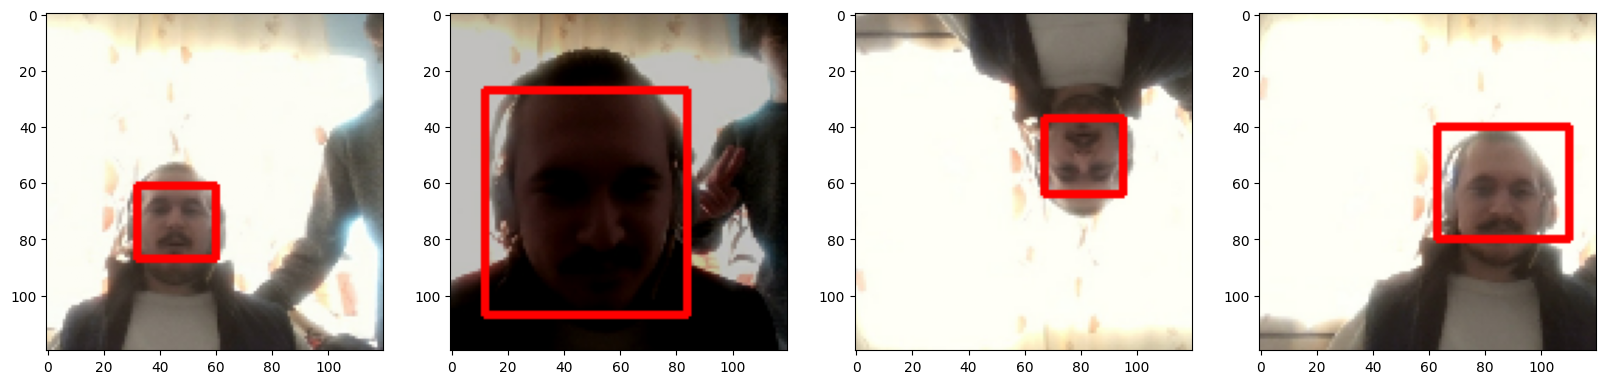

In [67]:
data_samples = train.as_numpy_iterator()
res = data_samples.next()
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

In [68]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [69]:
vgg = VGG16(include_top=False)
vgg.summary()



Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0   

In [70]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

In [71]:
facetracker = build_model()
facetracker.summary()
X, y = train.as_numpy_iterator().next()
X.shape
classes, coords = facetracker.predict(X)
classes, coords

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 120, 120, 3)]        0         []                            
                                                                                                  
 vgg16 (Functional)          (None, None, None, 512)      1471468   ['input_2[0][0]']             
                                                          8                                       
                                                                                                  
 global_max_pooling2d (Glob  (None, 512)                  0         ['vgg16[0][0]']               
 alMaxPooling2D)                                                                                  
                                                                                              

(array([[0.571671  ],
        [0.53869605],
        [0.5863193 ],
        [0.5604865 ],
        [0.5729076 ],
        [0.4912247 ],
        [0.53123224],
        [0.51014435]], dtype=float32),
 array([[0.46006075, 0.34381244, 0.5889831 , 0.5085409 ],
        [0.4278747 , 0.49987486, 0.52752185, 0.5064138 ],
        [0.5097226 , 0.33933383, 0.6164383 , 0.51718163],
        [0.49111718, 0.47427616, 0.5378674 , 0.5369051 ],
        [0.5713011 , 0.38481712, 0.5118928 , 0.5225755 ],
        [0.5062119 , 0.5361355 , 0.55583096, 0.5790468 ],
        [0.47200567, 0.3312404 , 0.6128899 , 0.5133649 ],
        [0.566716  , 0.47016728, 0.54843897, 0.5449102 ]], dtype=float32))

In [72]:
# Assuming 'train' is your training dataset
batches_per_epoch = len(train)

# Calculate the decay rate based on the formula (1./0.75 - 1) / batches_per_epoch
lr_decay = (1. / 0.75 - 1) / batches_per_epoch

# Set up the learning rate schedule
initial_learning_rate = 0.0001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=batches_per_epoch,  # Use batches_per_epoch as decay_steps
    decay_rate=0.75,  # You can adjust decay_rate based on your needs
    staircase=True)

# Create the Adam optimizer with the learning rate schedule
opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [73]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [74]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [75]:
localization_loss(y[1], coords)
classloss(y[0], classes)
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=6.3368816>

In [76]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [77]:
model = FaceTracker(facetracker)
model.compile(opt, classloss, regressloss)

In [78]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
630/630 [==============================] - 392s 613ms/step - total_loss: 0.3465 - class_loss: 0.0667 - regress_loss: 0.3132 - val_total_loss: 4.4663 - val_class_loss: 3.8819 - val_regress_loss: 2.5253
Epoch 2/10
630/630 [==============================] - 423s 667ms/step - total_loss: 0.1197 - class_loss: 0.0205 - regress_loss: 0.1094 - val_total_loss: 5.7244 - val_class_loss: 3.4319 - val_regress_loss: 4.0085
Epoch 3/10
630/630 [==============================] - 396s 624ms/step - total_loss: 0.0635 - class_loss: 0.0105 - regress_loss: 0.0582 - val_total_loss: 4.9939 - val_class_loss: 3.9382 - val_regress_loss: 3.0248
Epoch 4/10
630/630 [==============================] - 729s 1s/step - total_loss: 0.0327 - class_loss: 0.0047 - regress_loss: 0.0304 - val_total_loss: 6.7931 - val_class_loss: 5.9386 - val_regress_loss: 3.8238
Epoch 5/10
630/630 [==============================] - 1151s 2s/step - total_loss: 0.0231 - class_loss: 0.0048 - regress_loss: 0.0207 - val_total_loss: 5.20

In [79]:
hist.history

{'total_loss': [0.06393250077962875,
  0.046682555228471756,
  0.029351484030485153,
  0.025526734068989754,
  0.012313606217503548,
  0.36880335211753845,
  0.005438587628304958,
  0.008907103911042213,
  0.005276344250887632,
  0.0031900496687740088],
 'class_loss': [0.00027806489379145205,
  0.0035499990917742252,
  0.0066782631911337376,
  7.783114415360615e-05,
  0.00020887258870061487,
  0.14192746579647064,
  4.269214059604565e-06,
  1.990098644455429e-05,
  0.0002486809389665723,
  3.0459588742814958e-05],
 'regress_loss': [0.06379346549510956,
  0.04490755498409271,
  0.026012351736426353,
  0.02548781782388687,
  0.012209169566631317,
  0.29783961176872253,
  0.00543645303696394,
  0.008897153660655022,
  0.005152003839612007,
  0.0031748199835419655],
 'val_total_loss': [4.466299057006836,
  5.7244157791137695,
  4.993935585021973,
  6.793065071105957,
  5.206795692443848,
  5.1511688232421875,
  11.548545837402344,
  2.8710837364196777,
  3.009988784790039,
  5.636188507080

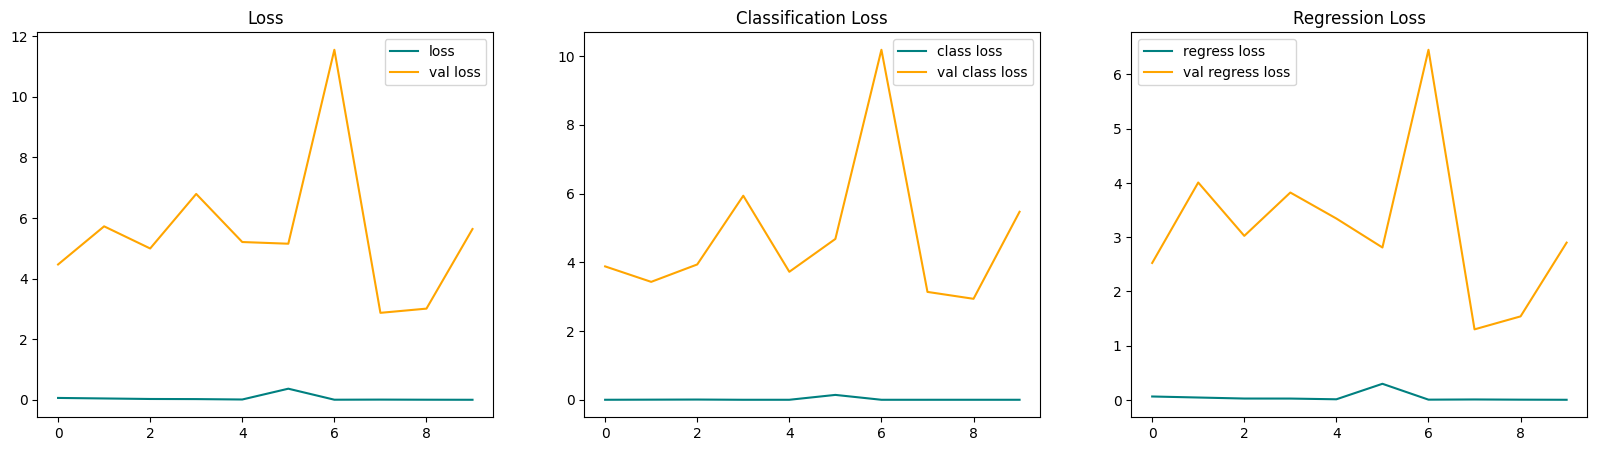

In [80]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

1/1 [==============================] - 0s 246ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


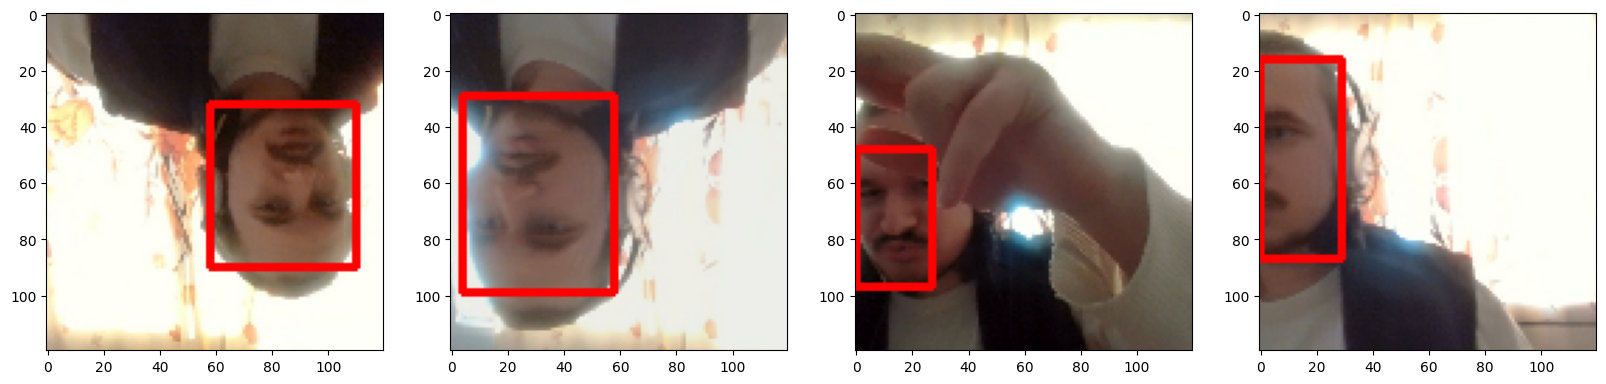

In [81]:
test_data = test.as_numpy_iterator()
test_sample = test_data.next()
yhat = facetracker.predict(test_sample[0])
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

In [82]:
from tensorflow.keras.models import load_model
facetracker.save('facetracker.h5')
facetracker = load_model('facetracker.h5')

c:\Users\Cem\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [88]:
cap = cv2.VideoCapture(0)
cv2.namedWindow('EyeTrack')
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    window_size = cv2.getWindowImageRect('EyeTrack')
    frame = cv2.resize(frame, (800, 600))
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 67ms/step


error: OpenCV(4.8.1) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window_w32.cpp:536: error: (-27:Null pointer) NULL window: 'EyeTrack' in function 'cvGetWindowRect_W32'
